In [5]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [8]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="4"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
config = dict(
    saved_path="saved/random.pt",
    best_saved_path = "saved/random_best.pt",
    lr=0.001, 
    EPOCHS = 3,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 32,
    TRAIN_VALID_SPLIT = 0.2,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=2,
    USE_AMP = True,
    channels_last=False)

In [21]:
random.seed(config['SEED'])
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG 
np.random.seed(config['SEED'])
# Prevent RNG for CPU and GPU using torch
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

In [22]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [23]:
train_data = torchvision.datasets.CIFAR10(root='../Images', train=True,
                                        download=True, transform=data_transforms['train'])
train_dl = torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])

test_data = torchvision.datasets.CIFAR10(root='../Images', train=False,
                                       download=True, transform=data_transforms['test'])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
valid_dl = test_dl

Files already downloaded and verified
Files already downloaded and verified


In [29]:
valid_data = test_data

tensor([3, 8, 8, 3, 1, 5, 3, 7, 3, 9, 4, 5, 4, 4, 0, 2, 1, 8, 6, 9, 5, 5, 0, 9,
        9, 6, 6, 9, 5, 4, 7, 1])


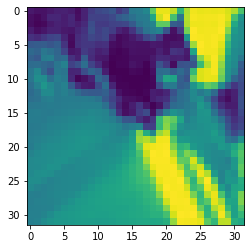

In [24]:
import matplotlib.pyplot as plt
a = iter(valid_dl)
b = next(a)
print(b[1])
plt.imshow(b[0][0][0])

In [33]:
def train_model(model,criterion,optimizer,num_epochs=10):

    since = time.time()                                            
    batch_ct = 0
    example_ct = 0
    best_acc = 0.3
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        run_corrects = 0
        #Training
        model.train()
        for x,y in train_dl: #BS=32 ([BS,3,224,224], [BS,4])            
            if config['channels_last']:
                x = x.to(config['device'], memory_format=torch.channels_last) #CHW --> #HWC
            else:
                x = x.to(config['device'])
            y = y.to(config['device']) #CHW --> #HWC
            
            
            
            optimizer.zero_grad()
            #optimizer.zero_grad(set_to_none=True)
            ######################################################################
            
            train_logits = model(x) #Input = [BS,3,224,224] (Image) -- Model --> [BS,4] (Output Scores)
            
            _, train_preds = torch.max(train_logits, 1)
            train_loss = criterion(train_logits,y)
            train_loss = criterion(train_logits,y)
            run_corrects += torch.sum(train_preds == y.data)
            
            train_loss.backward() # Backpropagation this is where your W_gradient
            loss=train_loss

            optimizer.step() # W_new = W_old - LR * W_gradient 
            example_ct += len(x) 
            batch_ct += 1
            if ((batch_ct + 1) % 400) == 0:
                train_log(loss, example_ct, epoch)
            ########################################################################
        
        #validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        # Disable gradient calculation for validation or inference using torch.no_rad()
        with torch.no_grad():
            for x,y in valid_dl:
                if config['channels_last']:
                    x = x.to(config['device'], memory_format=torch.channels_last) #CHW --> #HWC
                else:
                    x = x.to(config['device'])
                y = y.to(config['device'])
                valid_logits = model(x)
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
            
        epoch_loss = running_loss / len(valid_data)
        epoch_acc = running_corrects.double() / len(valid_data)
        train_acc = run_corrects.double() / len(train_data)
        print("Train Accuracy",train_acc.cpu())
        print("Validation Loss is {}".format(epoch_loss))
        print("Validation Accuracy is {}\n".format(epoch_acc.cpu()))
        if epoch_acc.cpu()>best_acc:
            print('One of the best validation accuracy found.\n')
            #torch.save(model.state_dict(), config['best_saved_path'])
            best_acc = epoch_acc.cpu()

            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    #torch.save(model.state_dict(), config['saved_path'])

    
def train_log(loss, example_ct, epoch):
    loss = float(loss)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model and set it to the GPU if available
model = Net()

In [35]:
model = model.to(config['device'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
train_model(model,criterion,optimizer,num_epochs=10)

Epoch 0/9
----------
Loss after 12768 examples: 1.871
Loss after 25568 examples: 1.927
Loss after 38368 examples: 1.923
Train Accuracy tensor(0.3144, dtype=torch.float64)
Validation Loss is 1.4533152322769165
Validation Accuracy is 0.4682

One of the best validation accuracy found.

Epoch 1/9
----------
Loss after 51152 examples: 1.729
Loss after 63952 examples: 1.740
Loss after 76752 examples: 1.231
Loss after 89552 examples: 1.395
Train Accuracy tensor(0.4025, dtype=torch.float64)
Validation Loss is 1.3180529211044312
Validation Accuracy is 0.5306000000000001

One of the best validation accuracy found.

Epoch 2/9
----------
Loss after 102336 examples: 1.710
Loss after 115136 examples: 1.803
Loss after 127936 examples: 1.578
Loss after 140736 examples: 1.728
Train Accuracy tensor(0.4510, dtype=torch.float64)
Validation Loss is 1.2299341583251953
Validation Accuracy is 0.5694

One of the best validation accuracy found.

Epoch 3/9
----------
Loss after 153520 examples: 1.093
Loss after 

# FGSM

In [36]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


In [62]:
def evaluate_fgsm(epsilon = 0.03):
    correct = 0
    total = 0

    #with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Set requires_grad flag to True
        images.requires_grad = True

        # Compute the gradient
        outputs = model(images)
        loss = criterion(outputs, labels)

        model.zero_grad()
        grad = torch.autograd.grad(loss, images, retain_graph=True, only_inputs=True)[0]
        data_grad = grad.data

        # Generate adversarial examples
        perturbed_images = fgsm_attack(images, epsilon, data_grad)
        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Reset requires_grad flag back to False
        images.requires_grad = False
    print('For Epsilon = ', epsilon)
    print('Accuracy on adversarial data: %d %%' % (100 * correct / total))
evaluate_fgsm()


For Epsilon =  0.03
Accuracy on adversarial data: 24 %


In [63]:
for e in [0,0.01,0.05,0.1]:
    evaluate_fgsm(e)
    print()

For Epsilon =  0
Accuracy on adversarial data: 29 %

For Epsilon =  0.01
Accuracy on adversarial data: 27 %

For Epsilon =  0.05
Accuracy on adversarial data: 22 %

For Epsilon =  0.1
Accuracy on adversarial data: 16 %

